In [2]:
import numpy as np
import yt          
from tqdm import tqdm
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

import sys
sys.path.append('./')
import flash

yt.set_log_level('ERROR')
%matplotlib inline

tqdm_format = '{desc:<5.5}{percentage:3.0f}%|{bar:20}{r_bar}'

In [3]:
Rsun = 6.957e10 # cm
Msun = 1.9884098706980504e33 # g

In [4]:
# Read progenitor profile and dat file
model = flash.model('model.1d')
dat = flash.dat('output.dat')

basename = './output/he_rsg_pf3p0_1d_hdf5_plt_cnt_'

In [5]:
# Get path to every plot file and only keep 1 every 10 file
plot_files = glob.glob(basename + '*')
plot_files.sort()
plot_files = plot_files[::10]
print(len(plot_files))

202


In [6]:
t = np.zeros(len(plot_files))
# Interpolate data for r = 10^5 - 10^10 cm on a logscale
r = np.logspace(5.0, 10.0, 1000)
dr = r - np.concatenate(((0,), r))[:-1]

enclosed_mass = np.zeros((len(t), len(r)))
dens = np.zeros((len(t), len(r)))
velx = np.zeros((len(t), len(r)))
entr = np.zeros((len(t), len(r)))
ye = np.zeros((len(t), len(r)))
sumy = np.zeros((len(t), len(r)))

# Read the plot files and interpolate the data
for i, file in tqdm(zip(range(len(plot_files)), plot_files), total=len(plot_files), bar_format=tqdm_format):
    ds = yt.load(file)
    ad = ds.all_data()

    t[i] = ds.current_time.v
    
    shell_mass = flash.calculate_shell_mass(ad['r'], ad['dr'], ad['dens'])
    enclosed_mass[i,:] = np.interp(r, ad['r'], shell_mass.cumsum())
    
    dens[i,:] = np.interp(r, ad['r'], ad['dens'])
    velx[i,:] = np.interp(r, ad['r'], ad['velx'])
    entr[i,:] = np.interp(r, ad['r'], ad['entr'])
    ye[i,:] = np.interp(r, ad['r'], ad['ye'])
    sumy[i,:] = np.interp(r, ad['r'], ad['sumy'])

     100%|████████████████████| 202/202 [01:28<00:00,  2.28it/s]


In [8]:
shock_times, shock_rad, shock_vel = flash.calculate_shock(dat['time'], dat['max_shock_radius'])

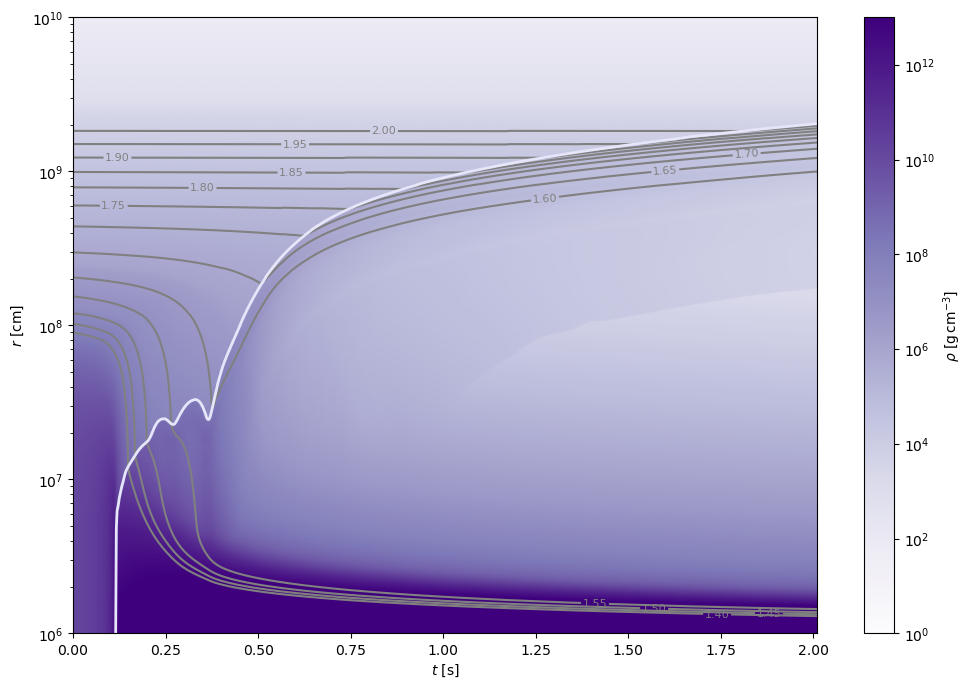

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

zlim = (1e0, 1e13)
pm = ax.pcolormesh(t, r, np.swapaxes(dens, 0, 1), cmap='Purples', norm=mpl.colors.LogNorm(vmin=zlim[0], vmax=zlim[1]), shading='gouraud')
contour = ax.contour(t, r, \
        np.swapaxes(enclosed_mass, 0, 1)/Msun, \
        levels=np.arange(1.4, 2.0, 0.05), \
        colors='gray')
ax.clabel(contour, inline=True, fontsize=8, inline_spacing=5)
ax.plot(shock_times, shock_rad, lw=2, c='lavender')
cbar = fig.colorbar(pm)
ax.set_xlim(t[0], t[-1])
ax.set_ylim(1e6, 1e10)
ax.set_yscale('log')

ax.set_xlabel(flash.get_plot_label('time'))
ax.set_ylabel(flash.get_plot_label('r'))
cbar.set_label(flash.get_plot_label('dens'))

plt.show()